# Setup

In [ ]:
# Installing Python libraries
!pip install pymongo==3.7.2 folium==0.9.1 geopandas==0.7.0 seaborn numpy tqdm

In [4]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import re

In [5]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

# Functions

In [6]:
def issue_map():
    """Get the custom issue mapping as a dictionary.
    """
    return dict(pd.read_csv('issue_map.csv').values)

# Cache as global variable here.
issue_dict = issue_map()
def standardize_issue_name(name):
    """Try to standardize issue types so they can be shown in less columns.
    """
    name = name.strip()
    return issue_dict[name] if name in issue_dict else name

def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    arr = lexicon.fillna('').astype(str).values.flatten().tolist()
    return [i for i in arr if i]

def lexicon_to_space_delimited():
    return " ".join(lexicon_to_array())

def find_all_issue_types():
    """Find all issue types so we can run multiple queries that may run different subsets, allowing for setting 0's.
    """
    all_issue_types = set()
    collections = db.list_collection_names()[:7]
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        all_issue_types.update(set([standardize_issue_name(row["_id"]) for row in query_count_by_issue_type_without_sum(db[name])]))
    return all_issue_types

def query_count_by_issue_type(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_without_sum(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name'} },
    ], collection)

def query_count_by_issue_type_having_comments(collection):
     return query_aggregate([
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments(collection):
    """ (DONT USE THIS) This solution uses a regex and is very slow (also the format is fucked up due to the projection).
    """
    return query_aggregate([
        { "$project": {
            "fields.comments": {
                "$filter": {
                    "input": "$fields.comments.body",
                    "as": "varcommentbody",
                    "cond": { "$regexMatch": { "input": "$$varcommentbody", "regex": "/" + "|".join(lexicon_to_array()) + "/", "options": "i" } },
                }
            }
        } },
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments_fts(collection):
    """Uses a full-text search.
    """
    # Create index for specific column. A collection can only have 1 text index and it is automatically the one used.
    collection.create_index([('fields.comments.body', pymongo.TEXT)], name='my_search_index', default_language='english')
    return query_aggregate([
        { "$match": { "$text": { "$search": lexicon_to_space_delimited() } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_get_issues_with_toxic_comments(collection, limit=5):
    return list(collection.find({ "$text": { "$search": lexicon_to_space_delimited() } }).limit(limit))


def query_aggregate(query, collection):
    """ Convenience wrapper to track time.
    """
    start = time.time()
    result = list(collection.aggregate(query))
    end = time.time()
    # print("Duration: {} seconds".format(end - start))
    return result

In [7]:
def find_comments_per_issue(query_fn_string, issue_types):
    """This function runs a count query per issue type on each collection in our Jira database. It might take a minute or so.
    
    TODO: filter comments by toxic words (hopefully i can just edit the mongodb query to accept a list)
    
    """
    data = []
    
    collections = db.list_collection_names()
    # collections = np.array(db.list_collection_names())[:2]
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        # Call function from string.
        result = globals()[query_fn_string](db[name])
        subdata = {};
        # Add any issue types with count data to the subdata.
        for row in result:
            issue_type = standardize_issue_name(row['_id'])
            if issue_type in subdata:
                subdata[issue_type] += row['count']
            else:
                subdata[issue_type] = row['count']
        data.append([name, subdata])
            
    # Fill in the complete matrix because issue types differ per subset.
    data2 = []
    for row in data:
        # First column = name
        subdata = [row[0]]
        for issue_type in issue_types:
            subdata.append(row[1][issue_type] if issue_type in row[1] else 0)
        data2.append(subdata)

    data2 = np.array(data2)
    # # Use first column as index, rest as the data.
    df = pd.DataFrame(np.array(data2[:,1:], dtype=np.int32), columns=list(issue_types), index=data2[:,0])   
    return df

In [21]:
def get_toxic_comments(collection, limit=5, colorize=True):
    def red(text):
        return "\x1b[31m" + text + "\x1b[0m"
    
    lexicon_regex = "|".join(['\\b' + i + "\\b" for i in lexicon_to_array()])
    results = query_get_issues_with_toxic_comments(collection, limit)
    comments = []
    for result in results:
        for comment in result['fields']['comments']:
            found = re.search(lexicon_regex, str(comment), re.IGNORECASE)
            if(found):
                comments.append("[FOUND: " + red(found.group()) + "] " + re.sub("\\b" + found.group() + "\\b", red(found.group()), comment['body']))
    return comments

# Execution + Results

In [63]:
all_issue_types = find_all_issue_types()
print(all_issue_types)
df_comments = find_comments_per_issue("query_count_by_issue_type_having_comments", all_issue_types)
df_toxic_comments = find_comments_per_issue("query_count_by_issue_type_having_toxic_comments_fts", all_issue_types)
print('Done')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.15s/it]


{'miscellaneous', 'development', 'improvement', 'bug', 'new', 'task', 'documentation', 'research', 'support', 'request', 'problem'}


Processing Jira: 100%|█████████████████████████████████████████████████████████████████| 16/16 [01:36<00:00,  6.04s/it]

Done


In [64]:
print(df_comments.shape)
print(df_toxic_comments.shape)

# Divide toxic comments by total comments to get a percentage.
df_div = df_toxic_comments.div(df_comments).fillna(0)

display(df_comments)
display(df_toxic_comments)
display(df_div)

(16, 11)
(16, 11)


,miscellaneous,development,improvement,bug,new,task,documentation,research,support,request,problem
SecondLife,0,0,0,241,44,231,0,295,0,0,948
IntelDAOS,0,0,0,3278,0,195,0,3815,0,0,0
Mojang,0,0,0,381027,0,0,0,0,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,0
Hyperledger,0,0,520,5970,596,6861,333,3609,0,0,0
Sonatype,0,0,1973,5489,65470,1032,0,167,9371,0,1594
Sakai,1080,58,5,29521,0,8250,0,1,0,5049,0
Qt,0,0,6,86955,0,11319,0,2368,11083,141,0
JFrog,0,0,940,3485,665,331,5,3,16,11,0
Spring,0,0,18763,24959,6294,9185,0,1532,180,0,269


,miscellaneous,development,improvement,bug,new,task,documentation,research,support,request,problem
SecondLife,0,0,0,71,11,46,0,132,0,0,335
IntelDAOS,0,0,0,1583,0,57,0,953,0,0,0
Mojang,0,0,0,165742,0,0,0,0,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,0
Hyperledger,0,0,32,1461,94,824,59,607,0,0,0
Sonatype,0,0,371,1262,13841,105,0,39,1342,0,332
Sakai,388,17,0,8025,0,1992,0,0,0,1321,0
Qt,0,0,2,25548,0,1765,0,508,2787,24,0
JFrog,0,0,143,804,125,39,1,1,4,5,0
Spring,0,0,3393,5938,1336,681,0,200,31,0,47


,miscellaneous,development,improvement,bug,new,task,documentation,research,support,request,problem
SecondLife,0.000000,0.000000,0.000000,0.294606,0.250000,0.199134,0.000000,0.447458,0.000000,0.000000,0.353376
IntelDAOS,0.000000,0.000000,0.000000,0.482916,0.000000,0.292308,0.000000,0.249803,0.000000,0.000000,0.000000
Mojang,0.000000,0.000000,0.000000,0.434988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MariaDB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hyperledger,0.000000,0.000000,0.061538,0.244724,0.157718,0.120099,0.177177,0.168191,0.000000,0.000000,0.000000
Sonatype,0.000000,0.000000,0.188039,0.229914,0.211410,0.101744,0.000000,0.233533,0.143208,0.000000,0.208281
Sakai,0.359259,0.293103,0.000000,0.271840,0.000000,0.241455,0.000000,0.000000,0.000000,0.261636,0.000000
Qt,0.000000,0.000000,0.333333,0.293807,0.000000,0.155933,0.000000,0.214527,0.251466,0.170213,0.000000
JFrog,0.000000,0.000000,0.152128,0.230703,0.187970,0.117825,0.200000,0.333333,0.250000,0.454545,0.000000
Spring,0.000000,0.000000,0.180835,0.237910,0.212266,0.074143,0.000000,0.130548,0.172222,0.000000,0.174721


In [65]:
def draw_heatmap(data, title, xlabel, ylabel, fmt='d'):
    ax = plt.axes()
    sns.heatmap(data, annot=True, square=True, fmt=fmt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    pass

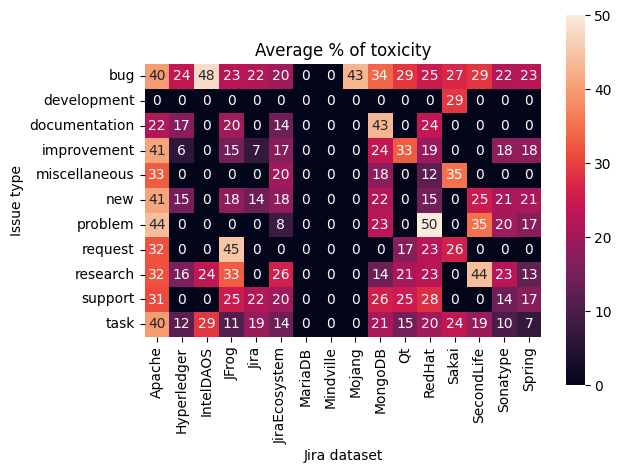

In [66]:
draw_heatmap(df_div.multiply(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Average % of toxicity', 'Jira dataset', 'Issue type')

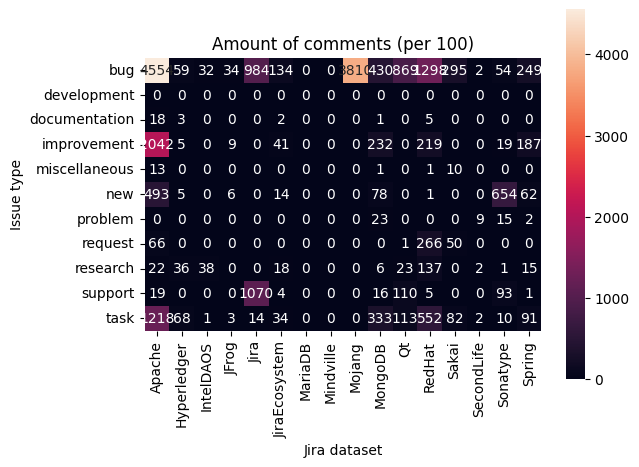

In [67]:
draw_heatmap(df_comments.divide(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Amount of comments (per 100)', 'Jira dataset', 'Issue type')

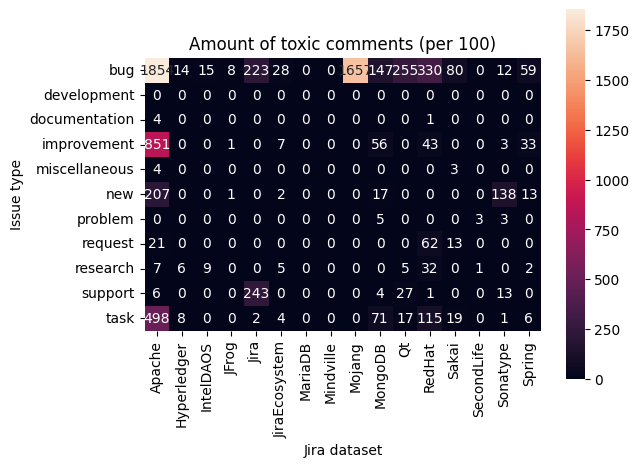

In [68]:
draw_heatmap(df_toxic_comments.divide(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Amount of toxic comments (per 100)', 'Jira dataset', 'Issue type')

In [ ]:
for name in db.list_collection_names():
    comments = get_toxic_comments(db[name], limit=1, colorize=True)
    print("Comments for '" + name + '"')
    for comment in comments:
        print(comment)